# Doc 6 - CNNs com balaceamento simples de dados e transfer learning

Neste notebook tentou-se fazer uma balanceamento para igualar o número de samples de cada uma das classes do test set da base de dados (aprox. 60 para cada classe). Para isso, usou-se a DenseNet com transfer learning.

Além disso, foi seguida a sugestão de fazer um resize para um dos valores das imagens do dataset e só depois fazer um downscale de 4.

## 1 - Análise inicial de dados

In [1]:
#Imports padrão para o desenvolvimento da rede e visualização do dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau #Interessante esse aqui - redução do LR se a validation n melhorar
from tensorflow.keras.applications import DenseNet121
from keras.applications import VGG16
from keras.models import Model

#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil
from pathlib import Path
import imagesize
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Frequencia de categoria one hot no dataset de teste')

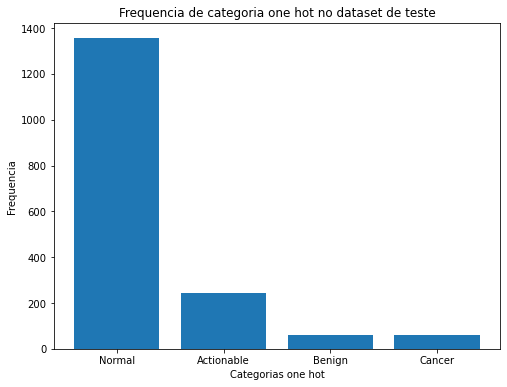

In [2]:
labels = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv") #Arquivo dos diagnosticos

one_hot_sum = labels[['Normal', 'Actionable', 'Benign', 'Cancer']].sum()

plt.figure(figsize=(8, 6))

plt.bar(['Normal', 'Actionable', 'Benign', 'Cancer'], one_hot_sum)

plt.xlabel('Categorias one hot')
plt.ylabel('Frequencia')
plt.title('Frequencia de categoria one hot no dataset de teste')

In [3]:
one_hot_sum

Normal        1356
Actionable     244
Benign          61
Cancer          60
dtype: int64

### 1.1 - Criando um dataset "balanceado"

Vamos balancear o dataset baixado fazendo com que todos tenham uma quantidade aproximadamente igual de imagens.

In [4]:
original_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\test"
balanced_folder = r"balanced_folder"

counts = {
    "normal": 60,
    "actionable": 60,
    "benign": 61,  
    "cancer": 60   
}

for category, count in counts.items():
    #Pega as classes
    category_images = os.listdir(os.path.join(original_folder, category))
    #Pega imagens aleatórias de cada classe
    random_images = random.sample(category_images, count)
    #Cria o folder da classe
    os.makedirs(os.path.join(balanced_folder, category), exist_ok=True)
    #Joga as imagens da classe no seu respectivo folder
    for image in random_images:
        shutil.copy(os.path.join(original_folder, category, image), os.path.join(balanced_folder, category))

In [5]:
# Analise das resolucoes das imagens actionable
file_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder\actionable\\'
actionable = [img.name for img in Path(file_path).iterdir() if img.suffix == ".png"]
actionable_meta = {}
for f in actionable: actionable_meta[str(f)] = imagesize.get(file_path+f)

#Conversao para um dataframe e analise das dimensoes
actionable_meta_df = pd.DataFrame.from_dict([actionable_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
actionable_meta_df[["Width", "Height"]] = pd.DataFrame(actionable_meta_df["Size"].tolist(), index=actionable_meta_df.index)
actionable_meta_df["Aspect Ratio"] = round(actionable_meta_df["Width"] / actionable_meta_df["Height"], 2)

print(f'Numero de imagens de diagnóstico actionable: {len(actionable_meta_df)}')
actionable_meta_df.head(10)

Numero de imagens de diagnóstico actionable: 60


,FileName,Size,Width,Height,Aspect Ratio
0,DBT-P00223_lmlo.png,"(1996, 2457)",1996,2457,0.81
1,DBT-P00223_rmlo.png,"(1996, 2457)",1996,2457,0.81
2,DBT-P00311_rcc.png,"(1996, 2457)",1996,2457,0.81
3,DBT-P00339_rmlo.png,"(1996, 2457)",1996,2457,0.81
4,DBT-P00455_rcc.png,"(1996, 2457)",1996,2457,0.81
5,DBT-P00556_rcc.png,"(1890, 2457)",1890,2457,0.77
6,DBT-P00817_lcc.png,"(1996, 2457)",1996,2457,0.81
7,DBT-P00935_rcc.png,"(1996, 2457)",1996,2457,0.81
8,DBT-P00984_lmlo.png,"(1890, 2457)",1890,2457,0.77
9,DBT-P00984_rcc.png,"(1890, 2457)",1890,2457,0.77


In [6]:
print(actionable_meta_df['Size'].value_counts())

(1996, 2457)    40
(1890, 2457)    20
Name: Size, dtype: int64


Text(0, 0.5, 'Height')

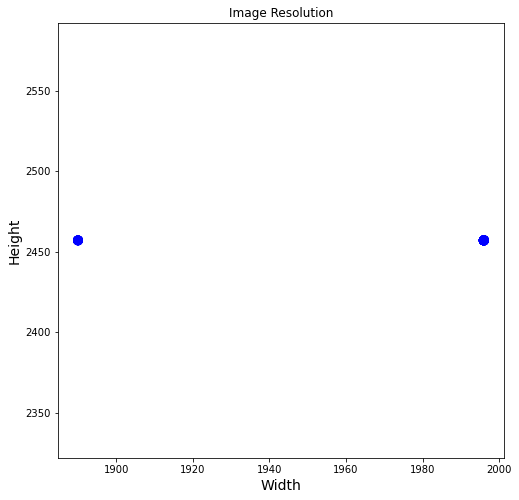

In [7]:
#Visualização das resoluções

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(actionable_meta_df.Width, actionable_meta_df.Height, color='blue', alpha=0.5, s=actionable_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [8]:
# Analise das resolucoes das imagens benign
file_path = r"D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder\benign\\"
benign = [img.name for img in Path(file_path).iterdir() if img.suffix == ".png"]
benign_meta = {}
for f in benign: benign_meta[str(f)] = imagesize.get(file_path+f)

#Conversao para um dataframe e analise das dimensoes
benign_meta_df = pd.DataFrame.from_dict([benign_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
benign_meta_df[["Width", "Height"]] = pd.DataFrame(benign_meta_df["Size"].tolist(), index=benign_meta_df.index)
benign_meta_df["Aspect Ratio"] = round(benign_meta_df["Width"] / benign_meta_df["Height"], 2)

print(f'Numero de imagens de diagnóstico benign: {len(benign_meta_df)}')
benign_meta_df.head(10)

Numero de imagens de diagnóstico benign: 61


,FileName,Size,Width,Height,Aspect Ratio
0,DBT-P00221_lcc.png,"(1890, 2457)",1890,2457,0.77
1,DBT-P00221_lmlo.png,"(1996, 2457)",1996,2457,0.81
2,DBT-P00332_rcc.png,"(1996, 2457)",1996,2457,0.81
3,DBT-P00332_rmlo.png,"(1996, 2457)",1996,2457,0.81
4,DBT-P00472_lcc.png,"(1890, 2457)",1890,2457,0.77
5,DBT-P00472_lmlo.png,"(1890, 2457)",1890,2457,0.77
6,DBT-P00629_lcc.png,"(1890, 2457)",1890,2457,0.77
7,DBT-P00629_lmlo.png,"(1890, 2457)",1890,2457,0.77
8,DBT-P00715_lcc.png,"(1996, 2457)",1996,2457,0.81
9,DBT-P00715_lmlo.png,"(1996, 2457)",1996,2457,0.81


In [9]:
print(benign_meta_df['Size'].value_counts())

(1996, 2457)    34
(1890, 2457)    27
Name: Size, dtype: int64


Text(0, 0.5, 'Height')

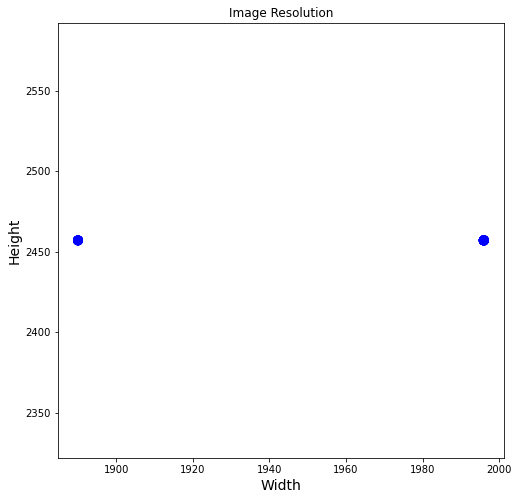

In [10]:
#Visualização das resoluções

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(benign_meta_df.Width, benign_meta_df.Height, color='blue', alpha=0.5, s=benign_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [11]:
# Analise das resolucoes das imagens cancer
file_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder\cancer\\'
cancer = [img.name for img in Path(file_path).iterdir() if img.suffix == ".png"]
cancer_meta = {}
for f in cancer: cancer_meta[str(f)] = imagesize.get(file_path+f)

#Conversao para um dataframe e analise das dimensoes
cancer_meta_df = pd.DataFrame.from_dict([cancer_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
cancer_meta_df[["Width", "Height"]] = pd.DataFrame(cancer_meta_df["Size"].tolist(), index=cancer_meta_df.index)
cancer_meta_df["Aspect Ratio"] = round(cancer_meta_df["Width"] / cancer_meta_df["Height"], 2)

print(f'Numero de imagens de diagnóstico cancer: {len(actionable_meta_df)}')
cancer_meta_df.head(10)

Numero de imagens de diagnóstico cancer: 60


,FileName,Size,Width,Height,Aspect Ratio
0,DBT-P00277_lcc.png,"(1890, 2457)",1890,2457,0.77
1,DBT-P00277_lmlo.png,"(1890, 2457)",1890,2457,0.77
2,DBT-P00318_rcc.png,"(1890, 2457)",1890,2457,0.77
3,DBT-P00318_rmlo.png,"(1890, 2457)",1890,2457,0.77
4,DBT-P00387_rcc.png,"(1996, 2457)",1996,2457,0.81
5,DBT-P00387_rmlo.png,"(1996, 2457)",1996,2457,0.81
6,DBT-P00659_lcc.png,"(1890, 2457)",1890,2457,0.77
7,DBT-P00659_lmlo.png,"(1890, 2457)",1890,2457,0.77
8,DBT-P00675_lcc.png,"(1996, 2457)",1996,2457,0.81
9,DBT-P00675_lmlo.png,"(1996, 2457)",1996,2457,0.81


In [12]:
print(cancer_meta_df['Size'].value_counts())

(1996, 2457)    36
(1890, 2457)    24
Name: Size, dtype: int64


Text(0, 0.5, 'Height')

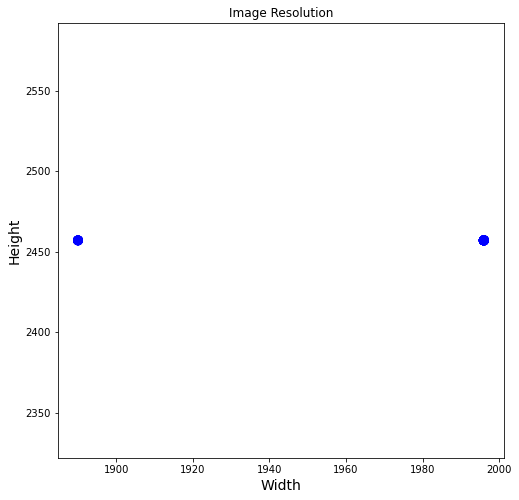

In [13]:
#Visualização das resoluções

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(actionable_meta_df.Width, actionable_meta_df.Height, color='blue', alpha=0.5, s=actionable_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [14]:
# Analise das resolucoes das imagens normais
file_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder\normal\\'
actionable = [img.name for img in Path(file_path).iterdir() if img.suffix == ".png"]
actionable_meta = {}
for f in actionable: actionable_meta[str(f)] = imagesize.get(file_path+f)

#Conversao para um dataframe e analise das dimensoes
actionable_meta_df = pd.DataFrame.from_dict([actionable_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
actionable_meta_df[["Width", "Height"]] = pd.DataFrame(actionable_meta_df["Size"].tolist(), index=actionable_meta_df.index)
actionable_meta_df["Aspect Ratio"] = round(actionable_meta_df["Width"] / actionable_meta_df["Height"], 2)

print(f'Numero de imagens de diagnóstico actionable: {len(actionable_meta_df)}')
actionable_meta_df.head(10)

Numero de imagens de diagnóstico actionable: 60


,FileName,Size,Width,Height,Aspect Ratio
0,DBT-P00021_lmlo.png,"(1890, 2457)",1890,2457,0.77
1,DBT-P00092_lcc.png,"(1996, 2457)",1996,2457,0.81
2,DBT-P00118_rmlo.png,"(1890, 2457)",1890,2457,0.77
3,DBT-P00192_lmlo.png,"(1890, 2457)",1890,2457,0.77
4,DBT-P00276_rmlo.png,"(1890, 2457)",1890,2457,0.77
5,DBT-P00339_rcc.png,"(1996, 2457)",1996,2457,0.81
6,DBT-P00392_lmlo.png,"(1890, 2457)",1890,2457,0.77
7,DBT-P00392_rmlo.png,"(1890, 2457)",1890,2457,0.77
8,DBT-P00471_lcc.png,"(1996, 2457)",1996,2457,0.81
9,DBT-P00496_lcc.png,"(1890, 2457)",1890,2457,0.77


In [15]:
print(actionable_meta_df['Size'].value_counts())

(1996, 2457)    35
(1890, 2457)    25
Name: Size, dtype: int64


Text(0, 0.5, 'Height')

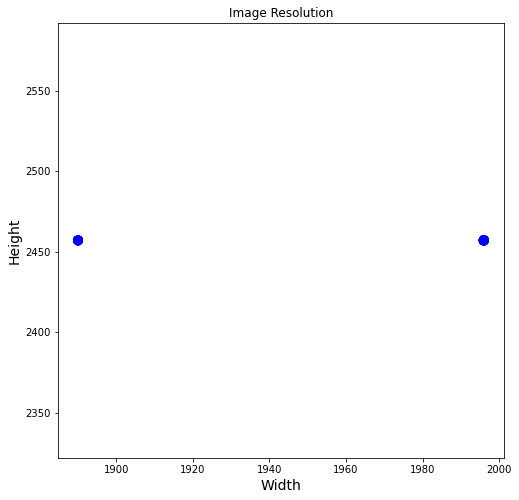

In [16]:
#Visualização das resoluções

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(actionable_meta_df.Width, actionable_meta_df.Height, color='blue', alpha=0.5, s=actionable_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

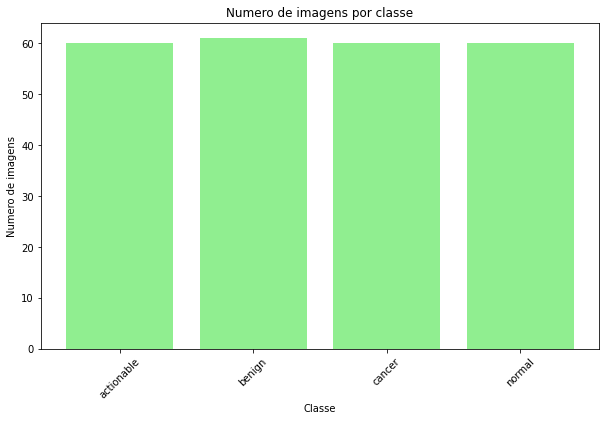

In [17]:
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder'

class_counts = {}
for class_name in os.listdir(folder_path):
    class_counts[class_name] = len(os.listdir(os.path.join(folder_path, class_name)))

# Plotting the counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.xlabel('Classe')
plt.ylabel('Numero de imagens')
plt.title('Numero de imagens por classe')
plt.xticks(rotation=45)
plt.show()

### 1.2 - Resize das imagens

Na última reunião, houve a proposta de dar o resize inicial das imagens para um dos dois que vimos que todas as imagens possui e só depois realizar o resize drástico para alimentar na rede, que foi o que foi feito aqui.

In [18]:
def resize_images(folder_path, target_size):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"): 
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                if image.size != target_size:
                    resized_image = image.resize(target_size, Image.ANTIALIAS)
                    resized_image.save(file_path)
                    

folder_path = r"D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6 - CNNs com balanceamento de dados\balanced_folder"
target_size = (1890, 2457) #Vamos primeiro dar o resize nas imagens que não têm essas dimensões.
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_14052\1364207737.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [19]:
#Agora damos um resize de 4 vezes menor.
target_size = (1890//4, 2457//4)
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_14052\1364207737.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


### 1.3 - Split dos dataset em train/val/test

In [20]:
input_folder = 'balanced_folder' 
output_folder = 'split_data' 

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None) #Train/val/test

Copying files: 241 files [00:01, 133.48 files/s]


In [21]:
data_dir = 'split_data'

#Definir dados de treinamento, validação e teste a partir das imagens que temos, aplicar normalização de pixels e categorização de labels
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size = (1890//4, 2457//4),
    batch_size=8,
    class_mode='categorical',
    shuffle = False
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size = (1890//4, 2457//4),
    batch_size=8,
    class_mode='categorical',
    shuffle = False
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size = (1890//4, 2457//4),
    batch_size=8,
    class_mode='categorical',
    shuffle = False
)

Found 168 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 37 images belonging to 4 classes.


## 2 - Transfer learning com DenseNet

In [22]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model_densenet = Model(inputs=base_model.input, outputs=predictions)

model_densenet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
#history_densenet = model_densenet.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping])
history_densenet = model_densenet.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.1971 - loss: 109.7686 - val_accuracy: 0.2222 - val_loss: 5.2137
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.3960 - loss: 4.1566 - val_accuracy: 0.3333 - val_loss: 1.4194
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.3905 - loss: 1.3536 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.3968 - loss: 1.3570 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.2239 - loss: 1.3539 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.3475 - loss: 1.3495 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.2820 - loss: 1.3414 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.3194 - loss: 1.3370 - val_accuracy: 0.2500 - val_loss: 1.386

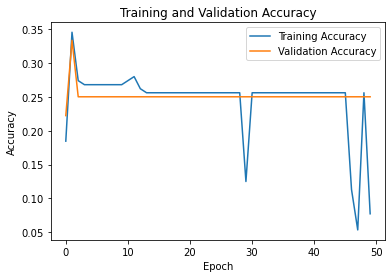

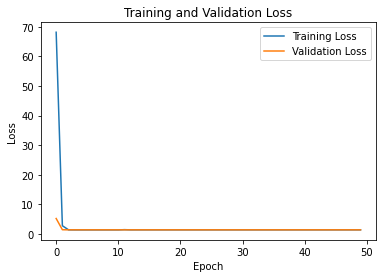

In [24]:
#Analise da precisao do treinamento e validacao
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
test_loss, test_accuracy = model_densenet.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.2845 - loss: 1.3852
Test Accuracy: 27.03%
Test Loss: 1.3858


In [26]:
predictions = model_densenet.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [27]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [28]:
#Pega os indices que foram classificados errados (i.e. vai pegar o indice dos dois arrays que estao diferentes EM VALOR)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype=int64)

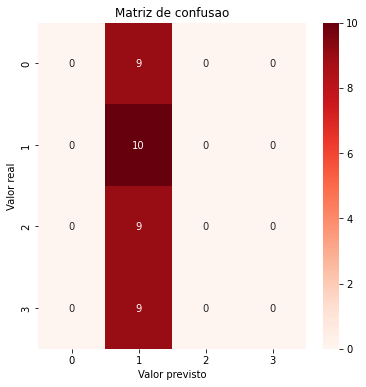

In [29]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

Podemos ver que em nenhum momento a rede foi capaz de aprender apropriadamente as classes das imagens.

## 3 - Transfer learning com VGG16

In [32]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelar os layers do modelo
for layer in vgg_model.layers:
    layer.trainable = False
    
#Adição dos layers finais
x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model_vgg16 = Model(inputs=vgg_model.input, outputs=predictions)

model_vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history_vgg16 = model_vgg16.fit(train_generator,
                epochs=50,
                validation_data=val_generator)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 222s 10s/step - accuracy: 0.2202 - loss: 26.4551 - val_accuracy: 0.2222 - val_loss: 2.8499
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 219s 10s/step - accuracy: 0.3257 - loss: 2.9263 - val_accuracy: 0.3889 - val_loss: 2.2482
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 220s 10s/step - accuracy: 0.4437 - loss: 2.5155 - val_accuracy: 0.2500 - val_loss: 2.3581
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 236s 11s/step - accuracy: 0.4615 - loss: 2.2105 - val_accuracy: 0.2500 - val_loss: 3.0699
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 237s 11s/step - accuracy: 0.3363 - loss: 2.3778 - val_accuracy: 0.2222 - val_loss: 2.8685
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 247s 12s/step - accuracy: 0.5867 - loss: 1.3486 - val_accuracy: 0.3611 - val_loss: 1.6568
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 235s 11s/step - accuracy: 0.9173 - loss: 0.4093 - val_accuracy: 0.3889 - val_loss: 1.6409
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 277s 13s/step - accuracy: 0.8670 - loss: 0.3541 - val_accuracy: 0

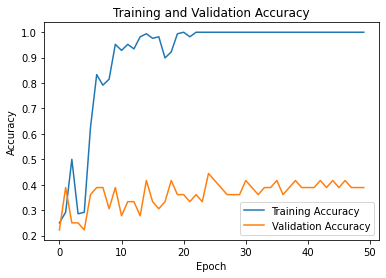

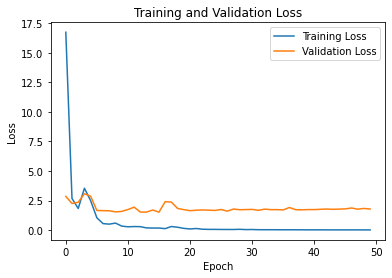

In [34]:
#Analise da precisao do treinamento e validacao
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.2585 - loss: 2.1677
Test Accuracy: 27.03%
Test Loss: 2.0363


In [36]:
predictions = model_vgg16.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step


array([3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 1, 3, 0, 2, 2, 3, 3, 2, 0, 3, 1, 1,
       0, 3, 1, 1, 0, 2, 3, 2, 1, 3, 1, 2, 3, 3, 3], dtype=int64)

In [37]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [38]:
#Pega os indices que foram classificados errados (i.e. vai pegar o indice dos dois arrays que estao diferentes EM VALOR)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_indices

array([ 0,  2,  4,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 29, 30, 32, 33], dtype=int64)

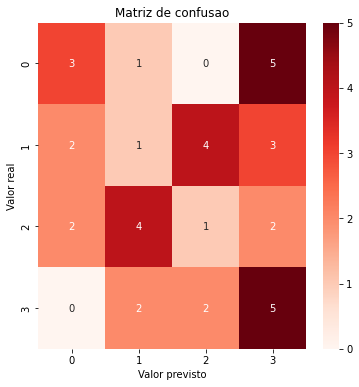

In [39]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()